<a href="https://colab.research.google.com/github/NituB22/AR-model/blob/main/ARmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda
from sklearn.metrics import precision_recall_fscore_support, classification_report
import random
random.seed(10)
tf.__version__

'2.8.2'

Training Set

In [4]:
data = pd.read_csv("trainingSet.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.tail(10)

,Unnamed: 0,sent_id,Word,TAG
724638,724638,30232,",",content
724639,724639,30232,not,content
724640,724640,30232,an,content
724641,724641,30232,echo,content
724642,724642,30232,",",content
724643,724643,30232,',content
724644,724644,30232,'',content
724645,724645,30232,she,source
724646,724646,30232,wrote,cue
724647,724647,30232,.,O


In [9]:
tags = list(set(data["TAG"].values))
tagCount = len(tags)
tagCount

4

In [10]:
tags

['content', 'source', 'O', 'cue']

In [11]:
class getSentence(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(), s["TAG"].values.tolist())]
        self.grouped = self.data.groupby("sent_id").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["{}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [12]:
getSen = getSentence(data)

In [15]:
sentences = getSen.sentences

In [26]:
max_len = 50
tag2id = {t: i for i, t in enumerate(tags)}

In [27]:
X_tr = [[w[0] for w in s] for s in sentences]

In [28]:
new_X = []
for seq in X_tr:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("__PAD__")
    new_X.append(new_seq)
X_tr = new_X

In [30]:
y_tr = [[tag2id[w[1]] for w in s] for s in sentences]

In [41]:
y_tr = pad_sequences(maxlen=max_len, sequences=y_tr, padding="post", value=tag2id["O"], truncating = 'post')

Validation Set

In [32]:
data = pd.read_csv("validationSet.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.tail(10)

,Unnamed: 0,sent_id,Word,TAG
78338,78338,3308,Reagan,content
78339,78339,3308,himself,content
78340,78340,3308,might,content
78341,78341,3308,have,content
78342,78342,3308,admired,content
78343,78343,3308,",",content
78344,78344,3308,'',content
78345,78345,3308,Barabak,source
78346,78346,3308,wrote,cue
78347,78347,3308,.,O


In [37]:
getSen = getSentence(data)
sentences = getSen.sentences

In [38]:
X_te = [[w[0] for w in s] for s in sentences]

In [39]:
new_X = []
for seq in X_te:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("__PAD__")
    new_X.append(new_seq)
X_te = new_X

In [40]:
y_te = [[tag2id[w[1]] for w in s] for s in sentences]

In [42]:
y_te = pad_sequences(maxlen=max_len, sequences=y_te, padding="post", value=tag2id["O"], truncating = 'post')

In [43]:
batch_size = 32

In [44]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

sess = tf.Session()
K.set_session(sess)

Instructions for updating:
non-resource variables are not supported in the long term


Elmo Embedding

In [45]:
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [46]:
def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

Building deep learning neural network

In [48]:
input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(None, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(tagCount, activation="softmax"))(x)

In [49]:
model = Model(input_text, out)

In [50]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# model.summary()

In [53]:
X_tr, X_val = X_tr[:944*batch_size], X_te[-103*batch_size:]
y_tr, y_val = y_tr[:944*batch_size], y_te[-103*batch_size:]
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

In [56]:
history = model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val),
                    batch_size=batch_size, epochs=5, verbose=1)

Train on 30208 samples, validate on 3296 samples
Epoch 1/5
30208/30208 [==============================] - ETA: 0s - loss: 0.2263 - acc: 0.9122

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


30208/30208 [==============================] - 384s 13ms/sample - loss: 0.2263 - acc: 0.9122 - val_loss: 0.1785 - val_acc: 0.9324
Epoch 2/5
30208/30208 [==============================] - 371s 12ms/sample - loss: 0.1676 - acc: 0.9361 - val_loss: 0.1725 - val_acc: 0.9333
Epoch 3/5
30208/30208 [==============================] - 371s 12ms/sample - loss: 0.1430 - acc: 0.9456 - val_loss: 0.1733 - val_acc: 0.9332
Epoch 4/5
30208/30208 [==============================] - 371s 12ms/sample - loss: 0.1184 - acc: 0.9557 - val_loss: 0.1788 - val_acc: 0.9347
Epoch 5/5
30208/30208 [==============================] - 370s 12ms/sample - loss: 0.0933 - acc: 0.9654 - val_loss: 0.1957 - val_acc: 0.9334


In [57]:
hist = pd.DataFrame(history.history)

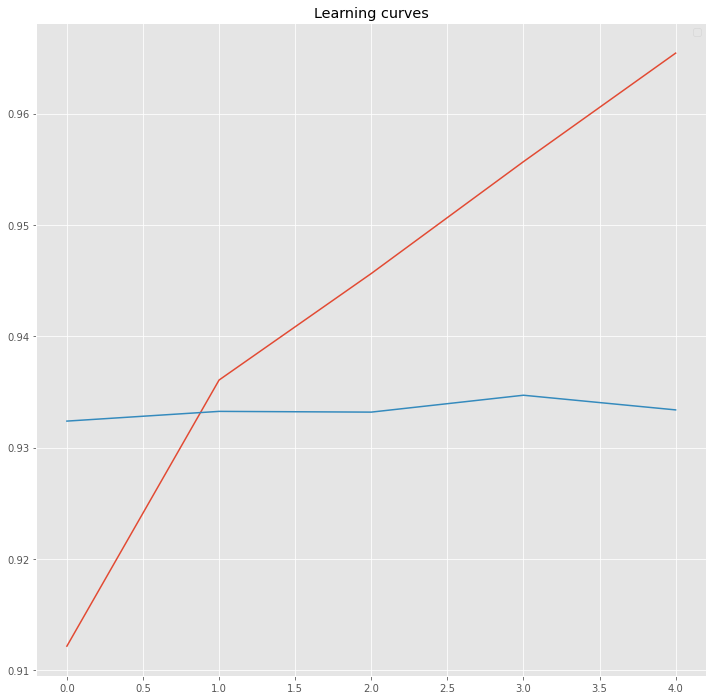

In [58]:

plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.title("Learning curves")
plt.legend()
plt.show()

Test Set

In [91]:
data = pd.read_csv("testSet.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.tail(10)

,Unnamed: 0,sent_id,Word,TAG
73360,73360,3022,``,content
73361,73361,3022,And,content
73362,73362,3022,I,content
73363,73363,3022,look,content
73364,73364,3022,so,content
73365,73365,3022,forward,content
73366,73366,3022,to,content
73367,73367,3022,it,content
73368,73368,3022,.,content
73369,73369,3022,'',content


In [92]:
getSen = getSentence(data)
sentences = getSen.sentences

In [93]:
X_test = [[w[0] for w in s] for s in sentences]

In [95]:
new_X = []
for seq in X_test:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("__PAD__")
    new_X.append(new_seq)
X_test = new_X

In [97]:
y_test = [[tag2id[w[1]] for w in s] for s in sentences]

In [99]:
y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding="post", value=tag2id["O"], truncating = 'post')

In [102]:
fileToWrite = open("test_output_wSentid","a")
fileToWrite.write("{:6}{:30}@#armo{:15}@#armo({})".format("sent_id","Word", "True", "Pred"))
fileToWrite.write("\n")
fileToWrite.write("="*30)
fileToWrite.write("\n")

i=0
print("{:6}{:30}@#armo{:15}@#armo({})".format("sent_id","Word", "True", "Pred"))
print("="*30)
while i<3022:
  p = model.predict(np.array(X_test[i:i+batch_size]))[0]
  p = np.argmax(p, axis=-1)
  for w, true, pred in zip(X_test[i], y_test[i], p):
    if w != "__PAD__":
      # print("{:20}:{:8} ({})".format(w, tags[true], tags[pred]))
      fileToWrite.write("{:6} {:30}@#armo{:15}@#armo({})".format(i+1, w, tags[true], tags[pred]))
      fileToWrite.write("\n")
  fileToWrite.write("="*30)
  fileToWrite.write("\n") 
  i = i+1
fileToWrite.close()

sent_idWord                          @#armoTrue           @#armo(Pred)


In [103]:
!head -n 30 test_output_wSentid

sent_idWord                          @#armoTrue           @#armo(Pred)
     1 Washington                    @#armosource         @#armo(source)
     1 Post                          @#armosource         @#armo(source)
     1 backs                         @#armocue            @#armo(cue)
     1 Hillary                       @#armocontent        @#armo(content)
     1 Clinton                       @#armocontent        @#armo(content)
     1 for                           @#armocontent        @#armo(content)
     1 president                     @#armocontent        @#armo(content)
     1 .                             @#armoO              @#armo(O)
     2 Washington                    @#armoO              @#armo(O)
     2 (                             @#armoO              @#armo(O)
     2 AFP                           @#armoO              @#armo(O)
     2 )                             @#armoO              @#armo(O)
     2 --                            @#armoO              @#armo(O)
     2 Th

In [104]:
fileRead = open("test_output_wSentid", "r")

In [105]:
f2 = fileRead.readlines()

In [106]:
len(f2)

75323

In [107]:
#Actually source, cue or content and predicted as the same
tp = 0
#Actually O but, predicted as source, cue or content
fp = 0
#Actually O and predicted as the same
tn = 0
#Actually source, cue or content but, predicted as O
fn = 0
tpAR = 0
tpARList = []
total = len(f2)
current_fp_fn =0
exact_sent_cnt =-1
senCount = -1
arSenIds = []
allZero = True
allZeroSenID = []
attriSenID = []
allZeroMatched = -1
total = len(f2)
for index in range(1, total):
    i = f2[index]
    if (i == "==============================\n"):
        senCount += 1
        new_fp_fn_cnt = fp + fn
        if (new_fp_fn_cnt == current_fp_fn):
            if allZero == True:
                allZeroMatched += 1
                if senCount>0:
                    allZeroSenID.append(senCount)  
            else:
                allZero = True
                if senCount>0:
                    attriSenID.append(senCount)
            exact_sent_cnt+=1
            if senCount>0:
                arSenIds.append(senCount)
        current_fp_fn = new_fp_fn_cnt
        continue
    tok = i.split('@#armo')
    try:
        actual = tok[1].strip()
        predicted = tok[2][1:-2].strip()
        if actual == 'O':
            if actual == predicted:
                tn += 1
#                 tnList.append(i)
            else:
                fp += 1
#                 fpList.append(i)
        else:
            allZero = False
            if actual == predicted:
                tp += 1
#                 tpList.append(i)
            else:
                fn += 1
#                 fnList.append(i)
    except IndexError:
        print(tok)
        break   
print("Total sentences= "+str(senCount))
print("Exact words match sentences ="+str(exact_sent_cnt))
print("Exact matching sentences Id list")
print(arSenIds[0:20])
print ("Number of sentences with all O = "+str(allZeroMatched))
print("All O sentence IDs")
print(allZeroSenID[0:10])
print("Attribution relations sentence IDs")
print(attriSenID[0:10])

Total sentences= 3022
Exact words match sentences =1833
Exact matching sentences Id list
[1, 3, 5, 8, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 28, 29, 30, 31]
Number of sentences with all O = 469
All O sentence IDs
[42, 58, 63, 67, 113, 115, 116, 120, 127, 131]
Attribution relations sentence IDs
[1, 3, 5, 8, 14, 15, 16, 17, 18, 19]


In [108]:
# Creating confusion matrix
import numpy as np
conf = np.zeros((4,4))
total = len(f2)
for index in range(1, total):
    i = f2[index]
    if (i == "==============================\n"):
        continue
    tok = i.split('@#armo')
    try:
        actual = tok[1].strip()
        predicted = tok[2][1:-2].strip()
        
        if actual == 'source':
            if actual == predicted:
                conf[0][0] += 1
            elif predicted == 'cue':
                conf[1][0] += 1
            elif predicted == 'content':
                conf[2][0] += 1
            else:
                conf[3][0] += 1
        if actual == 'cue':
            if actual == predicted:
                conf[1][1] += 1
            elif predicted == 'source':
                conf[0][1] += 1
            elif predicted == 'content':
                conf[2][1] += 1
            else:
                conf[3][1] += 1
        if actual == 'content':
            if actual == predicted:
                conf[2][2] += 1
            elif predicted == 'source':
                conf[0][2] += 1
            elif predicted == 'cue':
                conf[1][2] += 1
            else:
                conf[3][2] += 1
        if actual == 'O':
            if actual == predicted:
                conf[3][3] += 1
            elif predicted == 'source':
                conf[0][3] += 1
            elif predicted == 'cue':
                conf[1][3] += 1
            else:
                conf[2][3] += 1

    except IndexError:
        print(tok)
        break 
print(conf) 

[[ 4813.    51.   180.   777.]
 [   36.  2631.   294.   658.]
 [  192.   253. 32324.  3322.]
 [  543.   783.  3123. 22319.]]


In [109]:
# Token-wise performance
y_true = []
y_pred = []
total = len(f2)
for index in range(1, total):
    i = f2[index]
    if (i == "==============================\n"):
        continue
    tok = i.split('@#armo')
    actual = tok[1].strip()
    predicted = tok[2][1:-2].strip() 
    y_true.append(actual)
    y_pred.append(predicted)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           O       0.83      0.82      0.83     27076
     content       0.90      0.90      0.90     35921
         cue       0.73      0.71      0.72      3718
      source       0.83      0.86      0.84      5584

    accuracy                           0.86     72299
   macro avg       0.82      0.82      0.82     72299
weighted avg       0.86      0.86      0.86     72299

